## Project in Data Science : Predicting stock prices based on news and market data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

# Custom module kaggle.competitions.twosigmanews
from kaggle.competitions import twosigmanews

env = twosigmanews.make_env()

['marketdata_sample.csv', 'news_sample.csv']
Loading the data... This could take a minute.
Done!


In [2]:
# Import data
(market_train_df, news_train_df) = env.get_training_data()
market_train_df['date'] = market_train_df['time'].dt.strftime('%Y-%m-%d')

As my kernel died a lot inbetween fitting different models, I needed to take smaller train data

In [3]:
market_train_df=market_train_df.loc[market_train_df['time']>"2013-01-01",:]
news_train_df=news_train_df.loc[news_train_df['time']>"2013-01-01",:]

In [4]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
2354464,2013-01-02 22:00:00+00:00,A.N,Agilent Technologies Inc,6290038.0,41.88,42.17,0.022960,0.062484,-0.011745,0.028649,0.030503,0.057363,0.001360,0.047593,0.032719,1.0,2013-01-02
2354465,2013-01-02 22:00:00+00:00,AAN.N,Aaron's Inc,463556.0,28.70,28.72,0.014851,0.040957,-0.003633,0.058916,0.021716,0.043226,0.010621,0.041752,0.025683,1.0,2013-01-02
2354466,2013-01-02 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,800421.0,72.49,73.49,0.001935,0.029416,-0.006146,0.021011,-0.006849,0.008509,-0.003837,0.011423,-0.001499,1.0,2013-01-02
2354467,2013-01-02 22:00:00+00:00,AAPL.O,Apple Inc,20017838.0,549.03,554.00,0.031676,0.086083,-0.011501,0.051464,0.058208,0.088580,0.011897,0.066369,-0.068319,1.0,2013-01-02
2354468,2013-01-02 22:00:00+00:00,AAWW.O,Atlas Air Worldwide Holdings Inc,275066.0,45.58,45.54,0.028430,0.049551,0.006693,0.035086,0.084463,0.089474,0.076586,0.085146,-0.043747,0.0,2013-01-02


In [5]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
5275248,2013-01-01 00:01:30+00:00,2013-01-01 00:01:29+00:00,2013-01-01 00:01:29+00:00,046255936b3966b2,Plan to prevent spike in US milk prices stalle...,3,1,RTRS,"{'LAW', 'FOBE', 'MLK', 'USDA', 'FOD', 'GRA', '...","{'PGE', 'C', 'PCO', 'G', 'PCM', 'PCU', 'SOF', ...",3480,4,,False,26,643,{'DF.N'},Dean Foods Co,0,0.114708,-1,0.620525,0.252716,0.126759,643,0,0,0,0,0,0,0,0,0,0
5275249,2013-01-01 00:01:30+00:00,2013-01-01 00:01:29+00:00,2013-01-01 00:01:29+00:00,046255936b3966b2,Plan to prevent spike in US milk prices stalle...,3,1,RTRS,"{'LAW', 'FOBE', 'MLK', 'USDA', 'FOD', 'GRA', '...","{'PGE', 'C', 'PCO', 'G', 'PCM', 'PCU', 'SOF', ...",3480,4,,False,26,643,{'YUM.N'},Yum! Brands Inc,0,0.114708,-1,0.620525,0.252716,0.126759,643,0,0,0,0,0,0,0,0,2,3
5275250,2013-01-01 00:01:30+00:00,2013-01-01 00:01:29+00:00,2013-01-01 00:01:29+00:00,046255936b3966b2,Plan to prevent spike in US milk prices stalle...,3,1,RTRS,"{'LAW', 'FOBE', 'MLK', 'USDA', 'FOD', 'GRA', '...","{'PGE', 'C', 'PCO', 'G', 'PCM', 'PCU', 'SOF', ...",3480,4,,False,26,643,{'KRFT.O'},Kraft Foods Group Inc,0,0.114708,-1,0.620525,0.252716,0.126759,643,0,0,0,0,0,0,0,0,1,4
5275251,2013-01-01 00:22:30+00:00,2013-01-01 00:22:29+00:00,2013-01-01 00:22:29+00:00,f70c80c85d3bf10a,FACTBOX-Holdings of SPDR gold unchanged,3,1,RTRS,"{'PLAT', 'PREMTL', 'INVT', 'ZA', 'FINS', 'INVS...","{'SOF', 'C', 'MTL', 'GRO'}",5339,2,FACTBOX,False,13,672,{'SGOL.P'},ETFS Physical Swiss Gold Shares,5,0.674200,0,0.013672,0.800675,0.185653,463,0,2,3,5,6,0,2,3,5,6
5275252,2013-01-01 00:23:55+00:00,2013-01-01 00:23:55+00:00,2013-01-01 00:23:55+00:00,a80e684110dadec7,Reuters Insider - Stocks end 2012 with deal in...,3,1,RTRS,"{'FUND', 'LEN', 'FINS', 'MTVID', 'US', 'BNK', ...",{'RITV'},1734,1,,False,6,177,{'BAC.N'},Bank of America Corp,0,0.250000,1,0.008433,0.451409,0.540158,177,0,0,0,0,0,16,19,19,33,37


## Cleaning market data

There are various problems in market data. 
1. There seem to be some erroneous opening prices (max closing price 1578.13 vs max opening price 9998.99)
2. There is one asset that has two asset codes: "TW.N" and "WW.N", where the last one is erroneous.


<br>Used kernel:  https://www.kaggle.com/danielson/cleaning-up-market-data-errors-and-stock-splits

In [6]:
market_train_df.describe().round(3)

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,1.718492e+06,1718492.000,1718492.000,1718492.000,1718492.000,1711821.000,1711813.000,1718492.000,1718492.000,1682789.000,1682745.000,1718492.000,1718492.000
mean,2.429024e+06,47.221,47.211,0.001,0.001,0.000,0.000,0.006,0.006,-0.001,-0.000,-0.001,0.582
std,5.769091e+06,53.248,53.247,0.043,0.023,0.041,0.021,0.081,0.072,0.074,0.065,0.066,0.493
min,0.000000e+00,0.461,0.462,-0.978,-0.862,-1.236,-0.773,-0.977,-0.857,-3.343,-1.225,-1.232,0.000
25%,4.777390e+05,19.540,19.540,-0.009,-0.009,-0.008,-0.008,-0.028,-0.028,-0.028,-0.028,-0.028,0.000
50%,9.767150e+05,35.360,35.350,0.001,0.001,-0.000,0.000,0.005,0.005,-0.000,0.000,-0.000,1.000
75%,2.265774e+06,59.190,59.160,0.010,0.010,0.007,0.009,0.038,0.038,0.026,0.027,0.027,1.000
max,6.182376e+08,1578.130,1584.440,45.592,3.868,45.122,3.782,46.672,4.247,46.250,4.028,4.028,1.000


### 1. Fix the errors of returnsClosePrevRaw1  

From previous table, we can see that max open price is 9998.99 and closing price only 1578 - we should look into this. The returnsClosePrevRaw1 column shows us the daily drop or increase in stock price, from max value we get that biggest rise was 45.59 (4559% !!) and min shows that one stock decreased in value almost 100% in one day (-0.978 = -98%). 

In [7]:
# let's have a look on rows, that have more that 70% drop in one day
market_train_df[market_train_df['returnsClosePrevRaw1'] < -.7] 

#We can see that 4 of those have same date - 2016.07.07, let's take closer look on surrounding dates for these assets

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3474114,2015-09-09 22:00:00+00:00,TTPH.O,Tetraphase Pharmaceuticals Inc,23468076.0,9.49,9.64,-0.788075,-0.778340,-0.755343,-0.729875,-0.753826,-0.752821,-0.717449,-0.675231,0.064186,0.0,2015-09-09
3607400,2015-12-28 22:00:00+00:00,CMRX.O,Chimerix Inc,26705567.0,6.62,7.86,-0.813888,-0.778279,-0.811852,-0.773448,-0.812305,-0.780263,-0.794776,-0.784926,-0.163051,0.0,2015-12-28
3847265,2016-07-07 22:00:00+00:00,FLEX.O,Flex Ltd,4481469.0,11.80,11.81,-0.904415,-0.281630,-0.886907,-0.273703,-0.097859,-0.091538,-0.223552,-0.093630,-0.011186,1.0,2016-07-07
3847633,2016-07-07 22:00:00+00:00,MAT.O,Mattel Inc,2091099.0,32.34,32.14,-0.738032,0.492108,-0.731417,0.463413,0.006536,-0.001243,-0.040354,-0.003972,-0.077818,1.0,2016-07-07
3848074,2016-07-07 22:00:00+00:00,SHLD.O,Sears Holdings Corp,497204.0,13.40,13.27,-0.891472,0.501131,-0.875653,0.480682,-0.022611,-0.058865,-0.133526,-0.057434,0.032036,0.0,2016-07-07
3848433,2016-07-07 22:00:00+00:00,ZNGA.O,Zynga Inc,34888980.0,2.76,2.73,-0.977646,-0.252055,-0.899473,-0.242279,0.086614,0.058140,-0.614571,0.047817,-0.045813,0.0,2016-07-07
3938226,2016-09-16 22:00:00+00:00,NVAX.O,Novavax Inc,242232485.0,1.29,1.17,-0.845324,-0.862028,-0.835574,-0.763006,-0.810850,-0.829197,-0.832264,-0.868582,0.497091,0.0,2016-09-16


In [8]:
someAssetsWithBadData = ['FLEX.O','MAT.O','SHLD.O','ZNGA.O']
someMarketData = market_train_df[(market_train_df['assetCode'].isin(someAssetsWithBadData)) 
                & (market_train_df['time'] >= '2016-07-05')
                & (market_train_df['time'] < '2016-07-08')].sort_values('assetCode')
someMarketData

#From here we get that, all these have similar close value on 6th - 123.45 and 123.47.
# I would have a look on all data between these dates, seems like input error. close-open >=10

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3843668,2016-07-05 22:00:00+00:00,FLEX.O,Flex Ltd,3839393.0,11.66,11.70,-0.010187,-0.005102,-0.000815,-0.003561,-0.101695,-0.090909,-0.103166,-0.097041,-0.247207,1.0,2016-07-05
3845467,2016-07-06 22:00:00+00:00,FLEX.O,Flex Ltd,175451.0,123.45,16.44,9.587479,0.405128,9.482848,0.404713,8.503464,0.254962,8.425788,0.255200,0.087592,1.0,2016-07-06
3847265,2016-07-07 22:00:00+00:00,FLEX.O,Flex Ltd,4481469.0,11.80,11.81,-0.904415,-0.281630,-0.886907,-0.273703,-0.097859,-0.091538,-0.223552,-0.093630,-0.011186,1.0,2016-07-07
3844037,2016-07-05 22:00:00+00:00,MAT.O,Mattel Inc,3333108.0,31.62,31.46,0.002219,0.005433,0.014722,0.008522,-0.024676,-0.019021,-0.027185,-0.029008,0.396756,1.0,2016-07-05
3845835,2016-07-06 22:00:00+00:00,MAT.O,Mattel Inc,56994.0,123.45,21.54,2.904175,-0.315321,2.864919,-0.304480,2.842204,-0.334363,2.812233,-0.334071,-0.069237,1.0,2016-07-06
3847633,2016-07-07 22:00:00+00:00,MAT.O,Mattel Inc,2091099.0,32.34,32.14,-0.738032,0.492108,-0.731417,0.463413,0.006536,-0.001243,-0.040354,-0.003972,-0.077818,1.0,2016-07-07
3844479,2016-07-05 22:00:00+00:00,SHLD.O,Sears Holdings Corp,388228.0,12.98,13.63,-0.065515,0.009630,-0.054871,0.010488,-0.070201,-0.046853,-0.072216,-0.058148,0.541448,0.0,2016-07-05
3846276,2016-07-06 22:00:00+00:00,SHLD.O,Sears Holdings Corp,80940.0,123.47,8.84,8.512327,-0.351431,8.417827,-0.345786,7.781650,-0.370819,7.710716,-0.370630,0.059298,0.0,2016-07-06
3848074,2016-07-07 22:00:00+00:00,SHLD.O,Sears Holdings Corp,497204.0,13.40,13.27,-0.891472,0.501131,-0.875653,0.480682,-0.022611,-0.058865,-0.133526,-0.057434,0.032036,0.0,2016-07-07
3844838,2016-07-05 22:00:00+00:00,ZNGA.O,Zynga Inc,9732445.0,2.65,2.60,0.039216,0.044177,0.048598,0.045064,0.031128,0.044177,0.026816,0.029699,-0.306158,0.0,2016-07-05


In [9]:
#difference between close/open price is more than 10 (change in one day)
someMarketData2 = market_train_df[(market_train_df['time'] >= '2016-07-05') & (market_train_df['time'] < '2016-07-08') 
                                  & (market_train_df['close'] - market_train_df['open'] >=10)].sort_values('assetCode')
AssetsWithBadData=someMarketData2[(someMarketData2['close'] == 123.45)|(someMarketData2['close'] == 123.47)]['assetCode']
someMarketData2

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3844944,2016-07-06 22:00:00+00:00,AMZN.O,Amazon.com Inc,3938249.0,737.61,725.71,0.013061,0.004026,0.008342,0.004942,0.030441,0.013958,0.024262,0.014334,-0.020081,1.0,2016-07-06
3845015,2016-07-06 22:00:00+00:00,BBBY.O,Bed Bath & Beyond Inc,50303.0,123.45,30.68,1.921202,-0.295522,1.897847,-0.291610,1.849065,-0.303044,1.826249,-0.302549,-0.047101,1.0,2016-07-06
3845309,2016-07-06 22:00:00+00:00,DISH.O,DISH Network Corp,87466.0,123.47,63.29,1.430033,0.206903,1.407708,0.208864,1.325673,0.187207,1.295536,0.188725,-0.030583,1.0,2016-07-06
3845467,2016-07-06 22:00:00+00:00,FLEX.O,Flex Ltd,175451.0,123.45,16.44,9.587479,0.405128,9.482848,0.404713,8.503464,0.254962,8.425788,0.255200,0.087592,1.0,2016-07-06
3845835,2016-07-06 22:00:00+00:00,MAT.O,Mattel Inc,56994.0,123.45,21.54,2.904175,-0.315321,2.864919,-0.304480,2.842204,-0.334363,2.812233,-0.334071,-0.069237,1.0,2016-07-06
3845946,2016-07-06 22:00:00+00:00,NDAQ.O,Nasdaq Inc,113350.0,123.47,71.51,0.911596,0.122254,0.897776,0.122543,0.960775,0.135801,0.946862,0.136170,0.001852,1.0,2016-07-06
3846067,2016-07-06 22:00:00+00:00,PCAR.O,Paccar Inc,63374.0,123.45,66.41,1.445523,0.285521,1.420271,0.288671,1.261818,0.218979,1.242209,0.219653,0.030409,1.0,2016-07-06
3844271,2016-07-05 22:00:00+00:00,PCLN.O,Booking Holdings Inc,568815.0,1275.03,1259.56,0.006044,0.008447,0.021392,0.010721,-0.049875,-0.048412,-0.054914,-0.064660,-0.023824,1.0,2016-07-05
3846069,2016-07-06 22:00:00+00:00,PCLN.O,Booking Holdings Inc,562266.0,1292.04,1269.86,0.013341,0.008177,0.001566,0.013722,-0.037981,-0.055410,-0.047257,-0.054742,-0.018944,1.0,2016-07-06
3846151,2016-07-06 22:00:00+00:00,PZZA.O,Papa John's International Inc,25050.0,123.45,71.89,0.817580,0.056429,0.805544,0.056785,0.857229,0.076198,0.847870,0.076377,0.054807,0.0,2016-07-06


Turns out there are 9 assets with same error, next we will need to fix these errors. 


Assets: BBBY.O, DISH.O, FLEX.O, MAT.O, NDAQ.O, PCAR.O, PZZA.O, SHLD.O, ZNGA.O

In [10]:
assets=['ZNGA.O','FLEX.O','SHLD.O','MAT.O','BBBY.O','DISH.O','NDAQ.O', 'PCAR.O', 'PZZA.O']
for asset in assets:
    market_train_df = market_train_df[~((market_train_df['assetCode'] == asset)
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

### 2. There is one asset that has two asset codes: "TW.N" and "WW.N", where the last one is erroneous.

In [11]:
# Fix asset code "WW.N" and remove the observations with erroneous return data
market_train_df.loc[market_train_df['assetCode'] == 'WW.N','assetCode'] = 'TW.N'
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'TW.N')
                                  & (market_train_df['time'] >= '2009-12-16')
                                  & (market_train_df['time'] < '2010-01-08'))]


### 3. Drop some more rows with erroneous data.

In [12]:
# dropping Qorvo data through 2015-02-13
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'QRVO.O')
                                  & (market_train_df['time'] < '2015-02-14'))]

# dropping TECD.O data in Feb-May 2015
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'TECD.O')
                                  & (market_train_df['time'] >= '2015-01-30')
                                  & (market_train_df['time'] <= '2015-04-30'))]

# dropping EBR.N data in Oct 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'EBR.N')
                                  & (market_train_df['time'] >= '2016-10-01'))]

# dropping HGSI.O data in Feb and Mar 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'HGSI.O')
                                  & (market_train_df['time'] < '2009-04-01'))]


## Joining the market and news data
<br>
Most of the code is copied from public kernel: https://www.kaggle.com/bguberfain/a-simple-model-using-the-market-and-news-data and then modified for the set-up for this project.

In [13]:
# Different metrics to be calculated by every day about each asset. Aggregates multiple articles about certain asset in one day. 
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [14]:
def join_market_news(market_train_df, news_train_df):
    # Fix asset codes (str -> list)
    news_train_df['assetCodes2'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes2']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes2'].apply(len) )

    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Create expandaded news (will repeat every assetCodes' row)
    news_cols = ['time', 'assetCodes2'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

    # Free memory
    del news_train_df, df_assetCodes

    # Aggregate numerical news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    
    # Free memory
    del news_train_df_expanded

    # Convert to float32 to save memory
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flat columns
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join with train
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])

    # Free memory
    del news_train_df_aggregated
    
    return market_train_df

In [15]:
def get_xy(market_train_df, news_train_df, le=None):
    x, le = get_x(market_train_df, news_train_df)
    y = market_train_df['returnsOpenNextMktres10'].clip(-1, 1)
    return x, y, le


def label_encode(series, min_count):
    vc = series.value_counts()
    le = {c:i for i, c in enumerate(vc.index[vc >= min_count])}
    return le


def get_x(market_train_df, news_train_df, le=None):
    # Split date into before and after 22h (the time used in train data)
    # E.g: 2007-03-07 23:26:39+00:00 -> 2007-03-08 00:00:00+00:00 (next day)
    #      2009-02-25 21:00:50+00:00 -> 2009-02-25 00:00:00+00:00 (current day)
    news_train_df['time'] = (news_train_df['time'] - np.timedelta64(22,'h')).dt.ceil('1D')

    # Round time of market_train_df to 0h of curret day
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join market and news
    x = join_market_news(market_train_df, news_train_df)
    
    # If not label-encoder... encode assetCode
    if le is None:
        le_assetCode = label_encode(x['assetCode'], min_count=1)
        le_assetName = label_encode(x['assetName'], min_count=5)
    else:
        # 'unpack' label encoders
        le_assetCode, le_assetName = le
        
    x['assetCode'] = x['assetCode'].map(le_assetCode).fillna(-1).astype(int)
    x['assetName'] = x['assetName'].map(le_assetName).fillna(-1).astype(int)
    
    try:
        x.drop(columns=['returnsOpenNextMktres10'], inplace=True)
    except:
        pass
    try:
        x.drop(columns=['universe'], inplace=True)
    except:
        pass
    x['dayofweek'], x['month'] = x.time.dt.dayofweek, x.time.dt.month
    x.drop(columns='time', inplace=True)
#    x.fillna(-1000,inplace=True)

    # Fix some mixed-type columns
    for bogus_col in ['marketCommentary_min', 'marketCommentary_max']:
        x[bogus_col] = x[bogus_col].astype(float)
    
    return x, (le_assetCode, le_assetName)

In [16]:
from itertools import chain

# This will take some time...
X, y, le = get_xy(market_train_df, news_train_df)

In [17]:
# Save universe data for latter use
universe = market_train_df['universe']

In [18]:
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:], y.iloc[n_train:]

In [19]:
# For valid data, keep only those with universe > 0. This will help calculate the metric
u_valid = (universe.iloc[n_train:] > 0)
t_valid = market_train_df['time'].iloc[n_train:]

X_valid = X_valid[u_valid]
y_valid = y_valid[u_valid]
t_valid = t_valid[u_valid]

del u_valid

## Trying to fit different models

In the merged dataset we have rows for assets at certain dates, as shorn in next table. Every row contains market data (returns, volumes), and if there was some media coverage then also aggregated information about news data.


In [20]:
X.head()

,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,date,urgency_min,urgency_count,takeSequence_max,bodySize_min,bodySize_max,bodySize_mean,bodySize_std,wordCount_min,wordCount_max,wordCount_mean,wordCount_std,sentenceCount_min,sentenceCount_max,sentenceCount_mean,sentenceCount_std,companyCount_min,companyCount_max,companyCount_mean,companyCount_std,marketCommentary_min,marketCommentary_max,marketCommentary_mean,marketCommentary_std,relevance_min,relevance_max,relevance_mean,...,noveltyCount12H_mean,noveltyCount12H_std,noveltyCount24H_min,noveltyCount24H_max,noveltyCount24H_mean,noveltyCount24H_std,noveltyCount3D_min,noveltyCount3D_max,noveltyCount3D_mean,noveltyCount3D_std,noveltyCount5D_min,noveltyCount5D_max,noveltyCount5D_mean,noveltyCount5D_std,noveltyCount7D_min,noveltyCount7D_max,noveltyCount7D_mean,noveltyCount7D_std,volumeCounts12H_min,volumeCounts12H_max,volumeCounts12H_mean,volumeCounts12H_std,volumeCounts24H_min,volumeCounts24H_max,volumeCounts24H_mean,volumeCounts24H_std,volumeCounts3D_min,volumeCounts3D_max,volumeCounts3D_mean,volumeCounts3D_std,volumeCounts5D_min,volumeCounts5D_max,volumeCounts5D_mean,volumeCounts5D_std,volumeCounts7D_min,volumeCounts7D_max,volumeCounts7D_mean,volumeCounts7D_std,dayofweek,month
2354464,421,656,6290038.0,41.88,42.17,0.022960,0.062484,-0.011745,0.028649,0.030503,0.057363,0.001360,0.047593,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2354465,797,570,463556.0,28.70,28.72,0.014851,0.040957,-0.003633,0.058916,0.021716,0.043226,0.010621,0.041752,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2354466,238,589,800421.0,72.49,73.49,0.001935,0.029416,-0.006146,0.021011,-0.006849,0.008509,-0.003837,0.011423,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2354467,770,554,20017838.0,549.03,554.00,0.031676,0.086083,-0.011501,0.051464,0.058208,0.088580,0.011897,0.066369,2013-01-02,1.0,43.0,2.0,0.0,10253.0,3023.186035,2647.338135,10.0,2098.0,477.41861,563.825378,1.0,67.0,15.83721,17.492762,1.0,41.0,11.27907,13.450661,0.0,1.0,0.186047,0.39375,0.085126,1.0,0.602108,...,1.465116,1.709203,0.0,8.0,1.767442,2.068324,0.0,11.0,2.27907,2.657654,0.0,11.0,2.581395,2.727571,0.0,11.0,3.069767,3.34803,1.0,31.0,19.581396,9.424468,1.0,44.0,23.511627,13.140944,17.0,61.0,39.534885,13.178895,43.0,66.0,54.604652,6.72996,90.0,116.0,100.511627,7.666787,2,1
2354468,1202,1218,275066.0,45.58,45.54,0.028430,0.049551,0.006693,0.035086,0.084463,0.089474,0.076586,0.085146,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1





As not every row contains news data we train two models. One for the rows with news data and one for the rows without news data.

The model trained without news data will be fitted is linear regression. Tried also RF model for this, but linear regression gave better scores.

In [21]:
train_cols = X.columns.tolist()
#training columns for assets with news
u_train_cols = [
'volume','returnsOpenPrevMktres1', 'returnsOpenPrevMktres10','urgency_min', 'urgency_count',
 'takeSequence_max', 'bodySize_min', 'bodySize_max', 'bodySize_mean',
 'bodySize_std', 'wordCount_min', 'wordCount_max', 'wordCount_mean',
 'wordCount_std', 'sentenceCount_min', 'sentenceCount_max', 'sentenceCount_mean',
 'sentenceCount_std', 'companyCount_min', 'companyCount_max', 'companyCount_mean',
 'companyCount_std', 'marketCommentary_min', 'marketCommentary_max', 'marketCommentary_mean',
 'marketCommentary_std', 'relevance_min', 'relevance_max', 'relevance_mean',
 'relevance_std', 'sentimentNegative_min', 'sentimentNegative_max', 'sentimentNegative_mean',
 'sentimentNegative_std', 'sentimentNeutral_min', 'sentimentNeutral_max', 'sentimentNeutral_mean',
 'sentimentNeutral_std', 'sentimentPositive_min', 'sentimentPositive_max', 'sentimentPositive_mean',
 'sentimentPositive_std', 'sentimentWordCount_min', 'sentimentWordCount_max', 'sentimentWordCount_mean',
 'sentimentWordCount_std', 'noveltyCount12H_min', 'noveltyCount12H_max', 'noveltyCount12H_mean',
 'noveltyCount12H_std', 'noveltyCount24H_min', 'noveltyCount24H_max', 'noveltyCount24H_mean',
 'noveltyCount24H_std', 'noveltyCount3D_min', 'noveltyCount3D_max', 'noveltyCount3D_mean',
 'noveltyCount3D_std', 'noveltyCount5D_min', 'noveltyCount5D_max', 'noveltyCount5D_mean',
 'noveltyCount5D_std', 'noveltyCount7D_min', 'noveltyCount7D_max', 'noveltyCount7D_mean',
 'noveltyCount7D_std', 'volumeCounts12H_min', 'volumeCounts12H_max', 'volumeCounts12H_mean',
 'volumeCounts12H_std', 'volumeCounts24H_min', 'volumeCounts24H_max', 'volumeCounts24H_mean',
 'volumeCounts24H_std', 'volumeCounts3D_min', 'volumeCounts3D_max', 'volumeCounts3D_mean',
 'volumeCounts3D_std', 'volumeCounts5D_min', 'volumeCounts5D_max', 'volumeCounts5D_mean',
 'volumeCounts5D_std', 'volumeCounts7D_min', 'volumeCounts7D_max', 'volumeCounts7D_mean', 'volumeCounts7D_std']
#training columns for asset, that does not have news data
i_train_cols = ['dayofweek', 'month','volume', 'returnsOpenPrevMktres1', 'returnsOpenPrevMktres10']

In [22]:
# Funciton to separate rows with news data

def separate_rows_with_news(X, y, col, y_also=True):
    NA_indx=X[col].isnull()
    X_i=X.loc[NA_indx,:]
    X_u=X.loc[-NA_indx,:]
    X_u=X_u.fillna(0)
    X_i=X_i.fillna(0)
    if y_also==True:
        y_i=y.loc[NA_indx]
        y_u=y.loc[-NA_indx]
        return X_u, X_i, y_u, y_i
    else:
        return X_u, X_i

In [23]:
# Train two models - one for the part of data with some news about it, and other for the assets without news on certain date
def train_models(X_u,y_u, X_i, y_i, m_u, m_i, u_train_cols=u_train_cols, i_train_cols=i_train_cols):
    fitted_u=m_u.fit(X_u[u_train_cols], y_u)
    fitted_i=m_i.fit(X_i[i_train_cols], y_i)
    return fitted_u, fitted_i

# predictions for two models
def predict_from_fitted(X_u, X_i, fitted_u, fitted_i, u_train_cols=u_train_cols, i_train_cols=i_train_cols):
    pred_i=np.clip(fitted_i.predict(X_i[i_train_cols]),-1,1)
    pred_u=np.clip(fitted_u.predict(X_u[u_train_cols]),-1,1)
    return pred_u, pred_i

# Evaluation of score
def score(X_valid_u, X_valid_i, y_valid_u, y_valid_i,pred_u, pred_i):
    resid_u=pd.concat([X_valid_u['date'],pred_u*y_valid_u],axis=1)
    resid_i=pd.concat([X_valid_i['date'], pred_i*y_valid_i],axis=1)
    xts=[]
    for dt in X_valid_i['date'].unique():
        xt=resid_u.loc[resid_u['date']==dt,'returnsOpenNextMktres10'].sum()+resid_i.loc[resid_i['date']==dt,'returnsOpenNextMktres10'].sum()
        xts.extend([xt])
    return np.mean(xts)/np.std(xts)

In [24]:
X_u, X_i, y_u, y_i=separate_rows_with_news(X_train, y_train, 'urgency_min')
X_valid_u, X_valid_i, y_valid_u, y_valid_i=separate_rows_with_news(X_valid, y_valid, 'urgency_min')



## Model for the assets that did not have any news about it  (simple Linear Regression)

In [25]:
from sklearn.linear_model import LinearRegression

m_i=LinearRegression()


## Support Vector Machine models for data with news 


SVR - Epsilon-Support Vector Regression


In [26]:
from sklearn import svm

#m_u  = SVR(kernel='poly', degree=4, gamma="auto", C=1, max_iter=-1, tol=0.01)
#m_u  = SVR(kernel='rbf', gamma="auto", C=1, max_iter=-1, tol=0.01)
#m_u  = SVR(kernel='rbf', gamma="auto", shrinking=False, C=1, max_iter=-1, tol=0.01)
#m_u  = SVR(kernel='sigmoid', gamma="auto", C=1, max_iter=-1, tol=0.01)



All these model took really long time to run and I did not get any final models. After few hours of changing the parameters, googeling about the parameters, I finally googeled how to boost up SVR speed.

From this post here: https://www.reddit.com/r/MachineLearning/comments/1fvk15/ways_to_speedup_svr_training_in_scikitlearn/    I finally learned, that SVR can used only on training data with small datasets, i quote: "they hit a wall where they can't really deal with more than a few 10k training examples".

So I left SVM behind and started to try Gradient Boosting Methods as recommended in previous forum. 

## Regression with GradientBoosting

Documentation about GBR: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In [27]:
from  sklearn.ensemble import GradientBoostingRegressor

m_u=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
#score in my kernel - 0.32438431813304397 ---- best one I was able to model.
# Competition score: 0.49158

#m_u=GradientBoostingRegressor(n_estimators=200, learning_rate=0.3, max_depth=1, random_state=0)
#score in my kernel - 0.27901163396335305

#m_u=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
#score in my kernel - 0.2184884062075716

#m_u=GradientBoostingRegressor(n_estimators=200, learning_rate=0.5, max_depth=1, random_state=0)
#score in my kernel - 0.25002953881378237  

# n_estimator>200 takes too long time, that's why smaller values are prefferred

In [28]:
#m_u=GradientBoostingRegressor(loss='ls', 
 #                         learning_rate=0.5,
  #                        n_estimators=500,
   #                       subsample=1.0, 
    #                      criterion='friedman_mse', 
     #                     min_samples_split=4, 
      #                    min_samples_leaf=2, 
       #                   min_weight_fraction_leaf=0.0, 
        #                  max_depth=3, 
         #                 min_impurity_decrease=0.0, 
          #                min_impurity_split=None, 
           #               init=None, 
            #              random_state=0,
             #             max_features=None, 
              #            alpha=0.9, 
               #           verbose=0, 
                #          max_leaf_nodes=None, 
                 #         warm_start=False, 
                  #        presort='auto', 
                   #       validation_fraction=0.1,
                    #      n_iter_no_change=None, 
                     #     tol=0.01)

In [29]:
fitted_u, fitted_i=train_models(X_u,y_u, X_i, y_i, m_u, m_i, u_train_cols=u_train_cols, i_train_cols=i_train_cols)

In [30]:
pred_u, pred_i=predict_from_fitted(X_valid_u, X_valid_i, fitted_u, fitted_i, u_train_cols=u_train_cols, i_train_cols=i_train_cols)

In [31]:
score(X_valid_u, X_valid_i, y_valid_u, y_valid_i,pred_u, pred_i)

0.32438431813304397

#### Next, I will present a graph that shows differences between predicted values and actual values in test data.

count    67611.000000
mean        -0.002944
std          0.056749
min         -1.001844
25%         -0.027892
50%         -0.002318
75%          0.022819
max          0.943518
Name: returnsOpenNextMktres10, dtype: float64

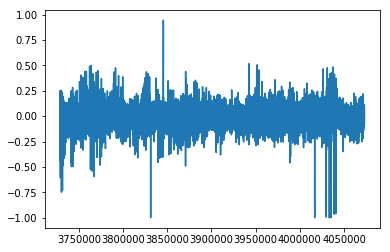

In [32]:
from matplotlib import pyplot as plt
plt.plot(pred_u-y_valid_u)
display ((pred_u-y_valid_u).describe())

### Writing submission file

As I am going to write another submission later, this section ic commeted out

In [33]:
# For merging together two sets of predictions
#def merge_predictions(X_valid_u, pred_u, X_valid_i, pred_i,le):
#    le_assetCode, le_assetName = le
#    assets=pd.DataFrame.from_dict(le_assetCode, orient='index').reset_index()
#    assets.columns=['character','assetCode']
#    result=pd.concat([pd.concat([X_valid_u['assetCode'].reset_index(),pd.DataFrame(pred_u)],axis=1),pd.concat([X_valid_i['assetCode'].reset_index(),pd.DataFrame(pred_i)],axis=1)],axis=0)
#    result=result.merge(assets,on='assetCode')
#    result=result.drop(['assetCode', 'index'], axis=1)
#    result.columns=['preds', 'assetCode']
#    result=result[['assetCode', 'preds']]
#    return result 

#def make_predictions(predictions_template_df, market_obs_df, news_obs_df):
#    x, le = get_x(market_obs_df, news_obs_df)
#    X_u, X_i=separate_rows_with_news(x, y_train, 'urgency_min', y_also=False)
#    pred_u, pred_i=predict_from_fitted(X_u, X_i, fitted_u, fitted_i, u_train_cols=u_train_cols, i_train_cols=i_train_cols)
#    
#    preds=merge_predictions(X_u, pred_u, X_i, pred_i,le)
#    
#    predictions_template_df=predictions_template_df.merge(preds, on='assetCode')
#    predictions_template_df=predictions_template_df.drop('confidenceValue', axis=1)
#    predictions_template_df.columns=['assetCode','confidenceValue']
#    return predictions_template_df

In [34]:
# The Main loop - to predict future dates:

#days = env.get_prediction_days()

#for (market_obs_df, news_obs_df, predictions_template_df) in days:
#    predictions=make_predictions(predictions_template_df, market_obs_df, news_obs_df)
#    env.predict(predictions)
#print('Done!')

In [35]:
#env.write_submission_file()

### Using LightGBM

The best model in previous section got only 0.49 score in competition scoring. So I decided to look other public kernels how others have improved their GBR models. Did not find much kernels, mainly GradientBoostingClafssifier was used. But as we didn't had binary data for other models. Later I tried for otherwise corrected data, where return was made binary. 

Found out that the public kernel we used for data merging, used LightGBR and so I continued with this method. 

https://www.kaggle.com/bguberfain/a-simple-model-using-the-market-and-news-data
Also some ideas from https://www.kaggle.com/alexfuyang/lgbmclassifier kernel were used. 

Help for choosing parameters:

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [36]:
X=X.drop(['date'], axis=1) # we need to erase date column, that was made for previous predictions
X_train=X_train.drop(['date'], axis=1)
X_valid=X_valid.drop(['date'], axis=1)

In [37]:
import lightgbm as lgb

# Creat lgb datasets
train_cols =X.columns.tolist()
categorical_cols = [] #['assetCode', 'assetName', 'dayofweek', 'month']

# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

In [38]:
# We will 'inject' an extra parameter in order to have access to df_valid['time'] inside sigma_score without globals
dvalid.params = {'extra_time' : t_valid.factorize()[0]}

In [60]:
import lightgbm as lgb
print ('Training lightgbm')

parameters = dict(objective = 'regression',
                  learning_rate = 0.3, #originally 0.1
                  num_leaves = 120, #originally 60
                  max_depth = -1,#no max. depth
                  bagging_fraction = 0.75,
                  bagging_freq = 2,
                  feature_fraction = 0.5,
                  lambda_l1 = 0.0,
                  lambda_l2 = 1.0,
                  metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
                  seed = 0)


def sigma_score(preds, valid_data):
    df_time = valid_data.params['extra_time']
    labels = valid_data.get_label()
    
#    assert len(labels) == len(df_time)

    x_t = preds * labels #  * df_valid['universe'] -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True

evals_result = {}
m = lgb.train(parameters, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, feval=sigma_score, evals_result=evals_result)


df_result = pd.DataFrame(evals_result['valid'])

Training lightgbm


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[25]	valid's sigma_score: 0.471704
[50]	valid's sigma_score: 0.457041
[75]	valid's sigma_score: 0.463759
[100]	valid's sigma_score: 0.472821
[125]	valid's sigma_score: 0.469917
[150]	valid's sigma_score: 0.477391
[175]	valid's sigma_score: 0.472434
[200]	valid's sigma_score: 0.479413
[225]	valid's sigma_score: 0.47272
[250]	valid's sigma_score: 0.465269
[275]	valid's sigma_score: 0.461361
Early stopping, best iteration is:
[188]	valid's sigma_score: 0.486687


In [61]:
num_boost_round, valid_score = df_result['sigma_score'].idxmax()+1, df_result['sigma_score'].max()
print(parameters)
print(f'Best score was {valid_score:.5f} on round {num_boost_round}')

{'objective': 'regression', 'learning_rate': 0.3, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
Best score was 0.48669 on round 188


### Restults for different models with different parameters

1) 'objective': 'regression_l1', 'learning_rate': 0.05, 'num_leaves': 127, 'max_depth': -1, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0
<br>
Best score was 0.37121 on round 449

2) 'objective': 'regression_l1', 'learning_rate': 0.5, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.41345 on round 57

3) {'objective': 'regression', 'learning_rate': 0.5, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.42150 on round 3

4) {'objective': 'regression', 'learning_rate': 0.5, 'num_leaves': 130, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.41214 on round 3

5) {'objective': 'regression', 'learning_rate': 0.3, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.48669 on round 188

6) {'objective': 'regression', 'learning_rate': 0.1, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.44123 on round 67

7) {'objective': 'regression', 'learning_rate': 0.3, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.5, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.43193 on round 28

8) {'objective': 'regression', 'learning_rate': 0.3, 'num_leaves': 120, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.3, 'metric': 'None', 'seed': 0}
<br>
Best score was 0.44648 on round 106

From the previous trials I chose the fifth one.

In [62]:
# Train full model with num_boost_round found in validation.
dtrain_full = lgb.Dataset(X, y, feature_name=train_cols, categorical_feature=categorical_cols)

model = lgb.train(parameters, dtrain, num_boost_round=num_boost_round)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [63]:
def make_predictions(predictions_template_df, market_obs_df, news_obs_df, le):
    x, _ = get_x(market_obs_df, news_obs_df, le)
    predictions_template_df.confidenceValue = np.clip(model.predict(x), -1, 1)

### Writing submission for competition

In [64]:
days = env.get_prediction_days()

for (market_obs_df, news_obs_df, predictions_template_df) in days:
    make_predictions(predictions_template_df, market_obs_df, news_obs_df, le)
    env.predict(predictions_template_df)
print('Done!')

Done!


In [ ]:
env.write_submission_file()